In [42]:
import glob
import re
import pickle
import numpy as np
import pandas as pd
import os
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
# sklearn
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#Deep
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import np_utils

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
path=r'dataset'
all_file=glob.glob(os.path.join(path+"/*.csv") )
li=[]
for filename in all_file:
    df=pd.read_csv(filename,index_col=None,header=None,encoding='latin-1',names=DATASET_COLUMNS)
    li.append(df)
df=pd.concat(li,axis=0,ignore_index=True)

In [25]:
df

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1600001,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1600002,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1600003,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1600004,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [26]:
df = df[['sentiment','text']]
df.sentiment=df.sentiment.replace(4,1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_9264\4101218951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sentiment=df.sentiment.replace(4,1)


In [27]:
df.describe

<bound method NDFrame.describe of          sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1600001          1  Just woke up. Having no school is the best fee...
1600002          1  TheWDB.com - Very cool to hear old Walt interv...
1600003          1  Are you ready for your MoJo Makeover? Ask me f...
1600004          1  Happy 38th Birthday to my boo of alll time!!! ...
1600005          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600006 rows x 2 columns]>

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

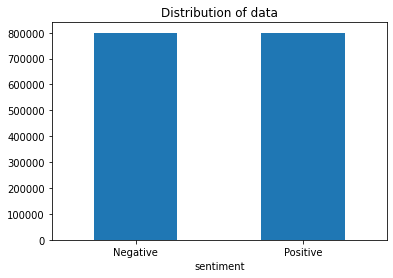

In [28]:
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [29]:
text, sentiment = list(df['text']), list(df['sentiment'])

In [30]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [31]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [32]:
for i in range(len(stopwordlist)):
    print(stopwordlist[i])

a
about
above
after
again
ain
all
am
an
and
any
are
as
at
be
because
been
before
being
below
between
both
by
can
d
did
do
does
doing
down
during
each
few
for
from
further
had
has
have
having
he
her
here
hers
herself
him
himself
his
how
i
if
in
into
is
it
its
itself
just
ll
m
ma
me
more
most
my
myself
now
o
of
on
once
only
or
other
our
ours
ourselves
out
own
re
s
same
she
shes
should
shouldve
so
some
such
t
than
that
thatll
the
their
theirs
them
themselves
then
there
these
they
this
those
through
to
too
under
until
up
ve
very
was
we
were
what
when
where
which
while
who
whom
why
will
with
won
y
you
youd
youll
youre
youve
your
yours
yourself
yourselves


In [33]:
from googletrans import Translator
from pprint import pprint

In [34]:
translator = Translator()
# Translate
textdata1=[]
def GG_Translate(text123):
    for i in range(0,len(text123)):
        translation = translator.translate(text123[i], dest="en")
        textdata1.append(translation.text)
    return(textdata1)

In [35]:
text5 = ['Tôi sắp phải lên trường rồi','Bây giờ là 1 giờ 14 phút chiều','tôi đang đi coffe một mình']
text4 = GG_Translate(text5)
print(text4)

["I'm going to go to school", 'The time now is 1:14 pm', 'I am going to coffee alone']


In [36]:

text_test='聞いてくれてありがとう'
result = translator.translate(text_test)
translation = translator.translate(text_test, dest="en")

print(translation.text)
print(result.src)
print(result.dest)
print(result.origin)
print(result.text)


Thank you for listening
ja
en
聞いてくれてありがとう
Thank you for listening


In [37]:
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        tweet = re.sub(urlPattern,' URL',tweet)
        
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        tweet = re.sub(userPattern,' USER', tweet)        
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet= re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # STEP 7 :Checking if the word is a stopword.
            #if word not in stopwordlist:
            # for i in range(len(stopwordlist)):
            #     print(stopwordlist[i])
            #STEP 8 :
            if len(word)>1:
                # STEP 9 :Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
        processedText.append(tweetwords)
    return processedText

In [38]:
import time
t = time.time()

In [43]:
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 139 seconds


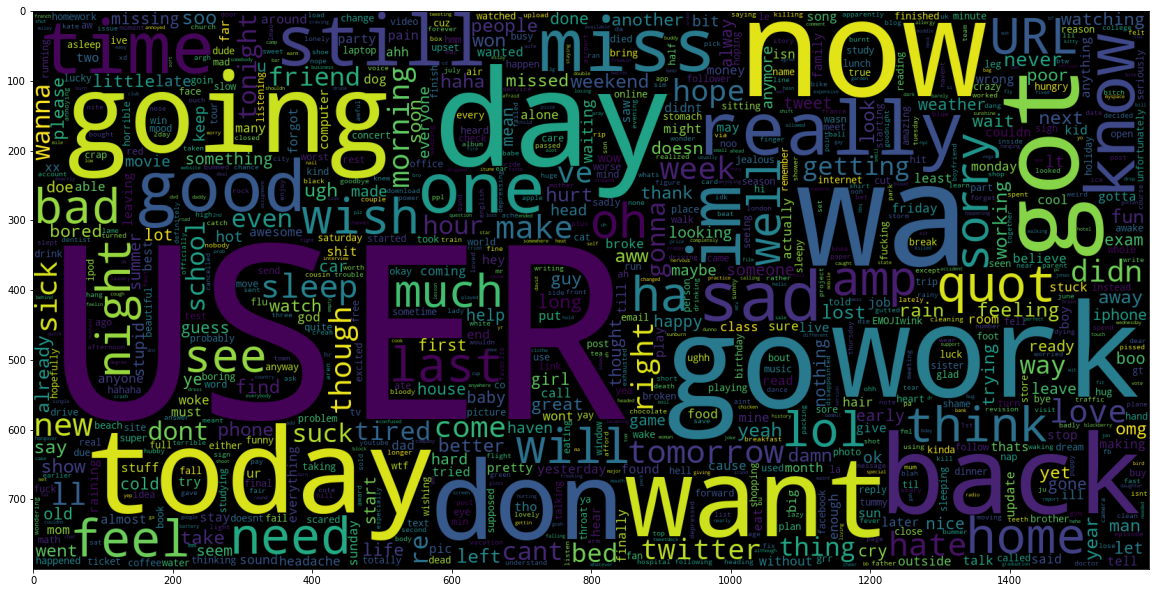

In [44]:
data_neg = np.random.choice(processedtext[:800000],size=400000)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

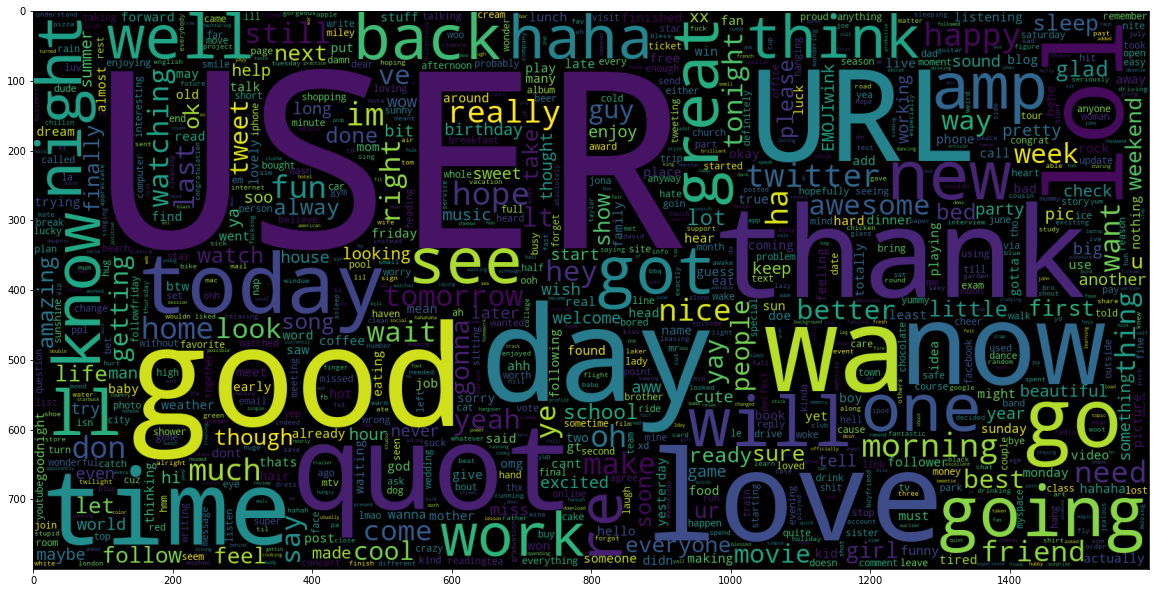

In [45]:
data_pos = np.random.choice(processedtext[800000:],size=400000)
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,test_size = 0.25, random_state = 0)

In [65]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [49]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    199823
           1       0.80      0.81      0.80    200179

    accuracy                           0.80    400002
   macro avg       0.80      0.80      0.80    400002
weighted avg       0.80      0.80      0.80    400002



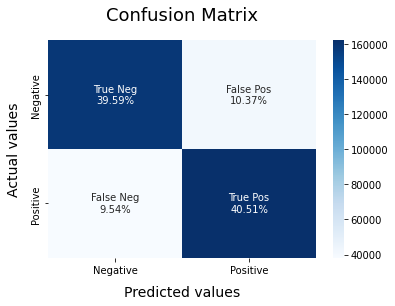

In [67]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    199823
           1       0.81      0.82      0.82    200179

    accuracy                           0.81    400002
   macro avg       0.81      0.81      0.81    400002
weighted avg       0.81      0.81      0.81    400002



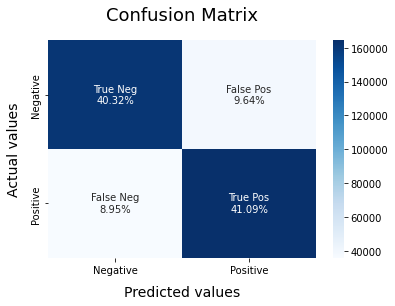

In [68]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    199823
           1       0.82      0.83      0.83    200179

    accuracy                           0.83    400002
   macro avg       0.83      0.83      0.83    400002
weighted avg       0.83      0.83      0.83    400002



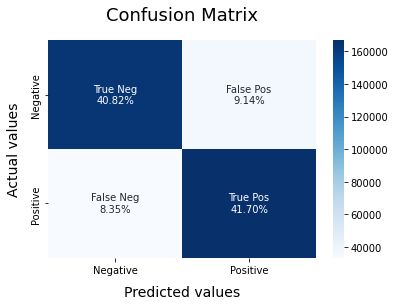

In [69]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [173]:
file = open('model/Sentiment-SVM.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('model/vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('model/Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('model/Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [29]:
def load_models():
    file = open('model/Sentiment-SVM.pickle','rb')
    SVCmodel = pickle.load(file)
    file.close()
    
    # Load the vectoriser.
    file = open('model/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('model/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    file = open('model/Sentiment-BNB.pickle', 'rb')
    BNBmodel = pickle.load(file)
    file.close()
    return vectoriser, LRmodel,BNBmodel,SVCmodel

In [54]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    # text1=GG_Translate(text)
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [61]:
if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    # Text to classify should be in a list.
    text = ["私は退屈です",
            "난 행복 해요",
            "hungrig",
            "fuck"]
    text1=GG_Translate(text)
    print(text1)
    df = predict(vectoriser, SVCmodel, text1)
    print(df.head())
    text1.clear()

["i'm bored", "I'm happy", 'hungry', 'fuck']
        text sentiment
0  i'm bored  Negative
1  I'm happy  Positive
2     hungry  Negative
3       fuck  Negative


In [70]:
#Danh gia model
accs = []
models=[]
accs.append(SVCmodel.score(X_test, y_test))
accs.append(LRmodel.score(X_test, y_test))
accs.append(BNBmodel.score(X_test, y_test))
models.append('SVC 2-8')
models.append('LogisticRegression 2-8')
models.append('BeaunarNB 2-8')

print("Accurency SVC: {}".format(SVCmodel.score(X_test, y_test)))
print("Accurency LR: {}".format(LRmodel.score(X_test, y_test)))
print("Accurency BNB: {}".format(BNBmodel.score(X_test, y_test)))


Accurency SVC: 0.8140959295203524
Accurency LR: 0.8251108744456278
Accurency BNB: 0.8009559952200239


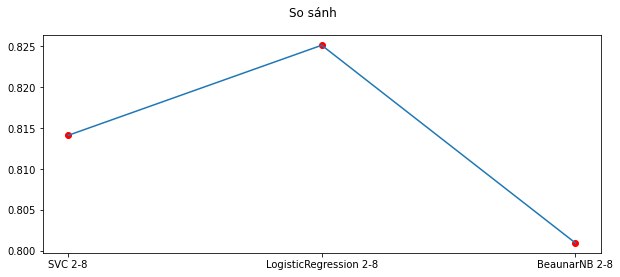

In [71]:
plt.figure(1,figsize=(10,4))
plt.plot(models,accs)
plt.scatter(models,accs,color = 'r')
plt.suptitle('So sánh')
plt.show()

In [59]:
#Dữ liệu 7-3
tile=[]
accs = []
models=[]
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,test_size = 0.25, random_state = 50000)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

accs = []
models=[]
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

accs.append(SVCmodel.score(X_test, y_test))
accs.append(LRmodel.score(X_test, y_test))
accs.append(BNBmodel.score(X_test, y_test))
models.append('SVC 2-8')
models.append('LogisticRegression 2-8')
models.append('BeaunarNB 2-8')

print("Accurency SVC: {}".format(SVCmodel.score(X_test, y_test)))
print("Accurency LR: {}".format(LRmodel.score(X_test, y_test)))
print("Accurency BNB: {}".format(BNBmodel.score(X_test, y_test)))

Vectoriser fitted.


c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000
Accurency SVC: 0.8129459352703237
Accurency LR: 0.8240108799456003
Accurency BNB: 0.8001759991200044


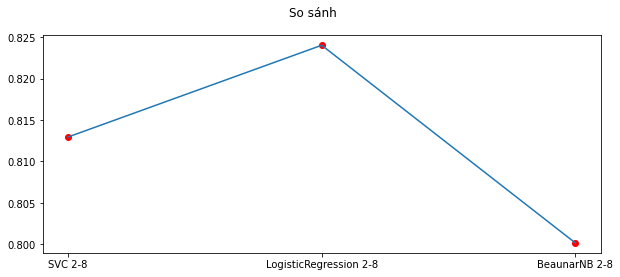

In [60]:
plt.figure(1,figsize=(10,4))
plt.plot(models,accs)
plt.scatter(models,accs,color = 'r')
plt.suptitle('So sánh')
plt.show()

In [125]:
X_train[:1000].toarray().shape

(1000, 500000)

In [132]:
X_train.shape[0]

1200004

In [174]:
model_ANN = Sequential()
model_ANN.add(Dense(128, input_dim=(X_train.shape[1]), activation='relu'))
model_ANN.add(Dense(128, activation='relu'))
model_ANN.add(Dense(64, activation='relu'))
model_ANN.add(Dense(16, activation='relu'))
model_ANN.add(Dense(8, activation='relu'))
model_ANN.add(Dense(1, activation='softmax'))
model_ANN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [172]:
model_ANN.fit(X_train.astype('float32'),np.asarray(y_train),epochs=1000,batch_size=2048)

Epoch 1/1000
586/586 [==============================] - 91s 151ms/step - loss: 0.0000e+00 - accuracy: 0.5002
Epoch 2/1000
586/586 [==============================] - 100s 166ms/step - loss: 0.0000e+00 - accuracy: 0.5002
Epoch 3/1000
586/586 [==============================] - 99s 162ms/step - loss: 0.0000e+00 - accuracy: 0.5002
Epoch 4/1000
128/586 [=====>........................] - ETA: 1:13 - loss: 0.0000e+00 - accuracy: 0.5015

KeyboardInterrupt: 

In [159]:
X_train.astype('float32')

<1200004x500000 sparse matrix of type '<class 'numpy.float32'>'
	with 24676453 stored elements in Compressed Sparse Row format>